In [33]:
import datetime
import os
import random
import numpy as np
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
import tensorflow as tf
import mlflow.keras
import importlib
import joblib
from sklearn.metrics import roc_auc_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sb
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


import ml_investing_wne.config as config
from ml_investing_wne.data_engineering.load_data import get_hist_data
from ml_investing_wne.data_engineering.prepare_dataset import prepare_processed_dataset
from ml_investing_wne.train_test_val_split import train_test_val_split
from ml_investing_wne.helper import confusion_matrix_plot, compute_profitability_classes
from ml_investing_wne.utils import get_logger

seed = 12345
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
                   

In [2]:
logger = get_logger()

In [3]:
df = get_hist_data(currency=config.currency)
df = prepare_processed_dataset(df=df)
X, y, X_val, y_val, X_test, y_test, y_cat, y_val_cat, y_test_cat, train = train_test_val_split(df)


2022-08-28 09:48:31,787 - ml_investing_wne.data_engineering.prepare_dataset - exported to /home/jupyter/ml_investing_wne/src/ml_investing_wne/data/processed/EURCHF/EURCHF_processed_720min.csv
2022-08-28 09:48:31,814 - ml_investing_wne.train_test_val_split - first sequence begins: 2010-01-24 12:00:00
2022-08-28 09:48:31,815 - ml_investing_wne.train_test_val_split - first sequence ends: 2010-03-25 00:00:00
2022-08-28 09:48:31,839 - ml_investing_wne.train_test_val_split - last sequence begins: 2019-10-30 12:00:00
2022-08-28 09:48:31,841 - ml_investing_wne.train_test_val_split - last sequence ends: 2019-12-30 12:00:00
2022-08-28 09:48:31,897 - ml_investing_wne.train_test_val_split - first sequence begins: 2019-11-13 12:00:00
2022-08-28 09:48:31,898 - ml_investing_wne.train_test_val_split - first sequence ends: 2020-01-14 00:00:00
2022-08-28 09:48:31,902 - ml_investing_wne.train_test_val_split - last sequence begins: 2020-10-29 12:00:00
2022-08-28 09:48:31,902 - ml_investing_wne.train_test_

In [4]:
model = load_model(os.path.join(config.package_directory, 'models', 'production',
                        '{}_{}_{}_{}_{}_{}'.format(config.model, 'hist_data',
                                                   config.currency, config.freq,
                                                   str(config.steps_ahead),
                                                   config.seq_len)))

2022-08-28 09:48:44.143801: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-28 09:48:44.143853: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-28 09:48:44.143876: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (python-20220811): /proc/driver/nvidia/version does not exist
2022-08-28 09:48:44.144116: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
y_pred = model.predict(X_test)

2022-08-28 09:48:48.043863: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [6]:
# max probability of price going down
y_pred[:,0].max()

0.5916158

In [433]:
np.where(y_pred[:,0]>0.58)

(array([120, 142, 153, 164]),)

In [8]:
np.where(y_pred>0.6)

(array([ 44,  55,  66,  77,  88,  99, 110, 121, 132, 143, 154, 165, 176,
        187, 198, 209, 220, 231, 242, 253, 264, 275, 286, 297, 308, 330,
        341, 352, 363, 374, 385, 396, 407, 418, 429, 440, 451, 462, 473]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))

In [449]:
obs= 418
# obs= 121

In [450]:
y_pred[obs,]

array([0.39174828, 0.6082517 ], dtype=float32)

In [451]:
y_test[obs]

1

In [452]:
from tensorflow import keras
intermediate_layer_model = keras.Model(inputs=model.input,
                                       outputs=model.get_layer('multi_head_attention').output)

In [453]:
layer_1_output = model.layers[1](X_test[obs:obs+1,:,:])
layer_2_output = model.layers[2](layer_1_output)
layer_3_output, viz_weights = model.layers[3](layer_2_output, layer_2_output, return_attention_scores=True)

In [454]:
intermediate_layer_model(X_test[obs:obs+1,:,:])

<tf.Tensor: shape=(1, 96, 40), dtype=float32, numpy=
array([[[-0.20473665,  1.2615074 , -0.06858537, ...,  0.06822301,
         -0.68197024, -1.021252  ],
        [-0.20486006,  1.3488473 , -0.0711429 , ...,  0.09934299,
         -0.58027625, -1.135541  ],
        [-0.20260537,  1.2237903 , -0.08739393, ...,  0.06114197,
         -0.67746216, -1.0369631 ],
        ...,
        [-0.22028676,  1.6850337 ,  0.15517284, ...,  0.14098397,
         -0.5785965 , -1.0789299 ],
        [-0.23557001,  1.6975377 ,  0.2041432 , ...,  0.13340516,
         -0.62880194, -1.0238665 ],
        [-0.22815481,  1.7755088 ,  0.1684277 , ...,  0.16820218,
         -0.47903284, -1.1737472 ]]], dtype=float32)>

In [455]:
layer_3_output

<tf.Tensor: shape=(1, 96, 40), dtype=float32, numpy=
array([[[-0.20473665,  1.2615074 , -0.06858537, ...,  0.06822301,
         -0.68197024, -1.021252  ],
        [-0.20486006,  1.3488473 , -0.0711429 , ...,  0.09934299,
         -0.58027625, -1.135541  ],
        [-0.20260537,  1.2237903 , -0.08739393, ...,  0.06114197,
         -0.67746216, -1.0369631 ],
        ...,
        [-0.22028676,  1.6850337 ,  0.15517284, ...,  0.14098397,
         -0.5785965 , -1.0789299 ],
        [-0.23557001,  1.6975377 ,  0.2041432 , ...,  0.13340516,
         -0.62880194, -1.0238665 ],
        [-0.22815481,  1.7755088 ,  0.1684277 , ...,  0.16820218,
         -0.47903284, -1.1737472 ]]], dtype=float32)>

In [456]:
viz_weights

<tf.Tensor: shape=(1, 4, 96, 96), dtype=float32, numpy=
array([[[[0.00558218, 0.00519085, 0.00551162, ..., 0.01221723,
          0.01317874, 0.01109962],
         [0.00361077, 0.00298008, 0.00338772, ..., 0.01009044,
          0.01258259, 0.00834804],
         [0.00551044, 0.00528676, 0.00550125, ..., 0.01290302,
          0.01319252, 0.01174835],
         ...,
         [0.00265865, 0.00212697, 0.00240239, ..., 0.01153666,
          0.0134912 , 0.00866173],
         [0.00318333, 0.00261436, 0.00290008, ..., 0.01485337,
          0.01698349, 0.0119407 ],
         [0.00128924, 0.00088986, 0.0010885 , ..., 0.00920776,
          0.01289941, 0.00638628]],

        [[0.0067101 , 0.00700689, 0.00656853, ..., 0.01130142,
          0.0113426 , 0.01183085],
         [0.00492346, 0.00416595, 0.00473995, ..., 0.01046732,
          0.01293505, 0.00939742],
         [0.00599646, 0.00623723, 0.00584545, ..., 0.01142033,
          0.01158885, 0.01196663],
         ...,
         [0.00642165, 0.00517764

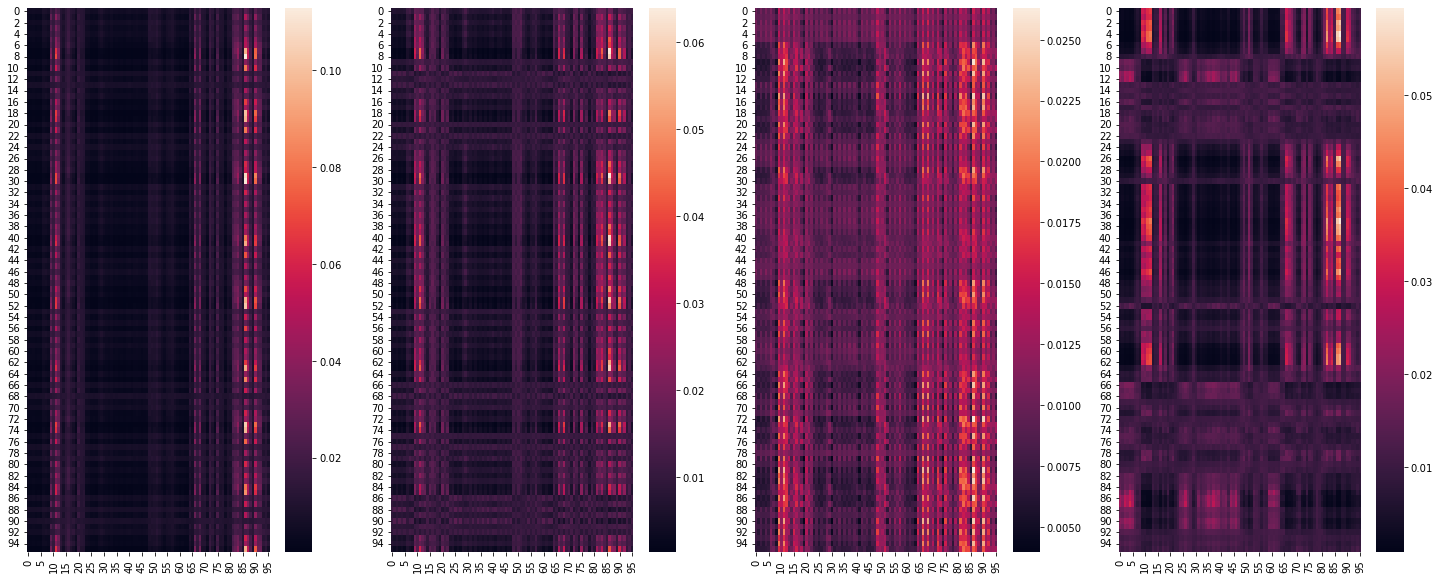

In [457]:
figure, axes = plt.subplots(1, 4, figsize=(25, 10))
index = 0
for i, axis in enumerate(axes):
    sb.heatmap(viz_weights[0, i, :, :], linewidth=0, ax=axis)
    index = index+1
plt.show()


In [458]:
average_score_per_day = {}
for i in range(viz_weights.shape[1]):
    average_score = np.mean(viz_weights[0, i, :, :].numpy(), axis=0)
    average_score_per_day['head_{}'.format(i)] = average_score

In [459]:
start_date = joblib.load(os.path.join(config.package_directory, 'models',
                                      'first_sequence_ends_{}_{}_{}.save'.format('test',
                                                                                 config.currency,
                                                                                 config.freq)))
end_date = joblib.load(os.path.join(config.package_directory, 'models',
                                    'last_sequence_ends_{}_{}_{}.save'.format('test',
                                                                              config.currency,
                                                                              config.freq)))

In [460]:
prediction = df.loc[(df.datetime >= start_date) & (df.datetime <= end_date)]

In [461]:
prediction.reset_index(inplace=True, drop=True)

In [462]:
sequence = prediction.iloc[(obs-config.seq_len+1):obs+3,:].reset_index(drop=True)

In [463]:
sequence.shape

(98, 42)

In [464]:
sequence

datetime     open     high      low    close  y_pred     SMA_3  \
0  2021-08-10 00:00:00  1.07965  1.08177  1.07958  1.08142       0  1.080273   
1  2021-08-10 12:00:00  1.08142  1.08183  1.08007  1.08121       1  1.080757   
2  2021-08-11 00:00:00  1.08120  1.08241  1.08101  1.08159       1  1.081407   
3  2021-08-11 12:00:00  1.08160  1.08259  1.08130  1.08197       1  1.081590   
4  2021-08-12 00:00:00  1.08198  1.08335  1.08158  1.08316       1  1.082240   
..                 ...      ...      ...      ...      ...     ...       ...   
93 2021-10-07 12:00:00  1.07275  1.07379  1.07188  1.07364       0  1.072740   
94 2021-10-08 00:00:00  1.07365  1.07516  1.07205  1.07289       1  1.073097   
95 2021-10-08 12:00:00  1.07289  1.07316  1.07210  1.07295       1  1.073160   
96 2021-10-10 12:00:00  1.07223  1.07464  1.07207  1.07438       0  1.073407   
97 2021-10-11 00:00:00  1.07437  1.07442  1.07092  1.07246       0  1.073263   

       EMA_3         VAR_3     SMA_5  ...  BBU_5_2.0  BBB_5_2.0  BBP_5_2.0  \
0   1.080021  9.897333e-07  1.078442  ...   1.083125   0.868490   0.817953   
1   1.080615  9.462333e-07  1.079620  ...   1.083456   0.710562   0.707264   
2   1.081103  3.623333e-08  1.080724  ...   1.082415   0.312963   0.756041   
3   1.081536  1.444000e-07  1.081166  ...   1.082771   0.296961   0.750417   
4   1.082348  6.709000e-07  1.081870  ...   1.083253   0.255654   0.966403   
..       ...           ...       ...  ...        ...        ...        ...   
93  1.073218  8.284000e-07  1.073266  ...   1.077110   0.716394   0.548642   
94  1.073054  2.256333e-07  1.072490  ...   1.074121   0.304225   0.622595   
95  1.073002  1.737000e-07  1.072812  ...   1.073977   0.217247   0.559211   
96  1.073691  7.114333e-07  1.073324  ...   1.074544   0.227381   0.932692   
97  1.073075  9.952333e-07  1.073264  ...   1.074612   0.251215   0.201803   

       roc_1  hour  weekday      hour_sin  hour_cos   weekday_sin  weekday_cos  
0   1.001649     0        1  0.000000e+00       1.0  8.660254e-01          0.5  
1   0.999806    12        1 -2.449294e-16       1.0  8.660254e-01          0.5  
2   1.000351     0        2  0.000000e+00       1.0  8.660254e-01         -0.5  
3   1.000351    12        2 -2.449294e-16       1.0  8.660254e-01         -0.5  
4   1.001100     0        3  0.000000e+00       1.0  1.224647e-16         -1.0  
..       ...   ...      ...           ...       ...           ...          ...  
93  1.000820    12        3 -2.449294e-16       1.0  1.224647e-16         -1.0  
94  0.999301     0        4  0.000000e+00       1.0 -8.660254e-01         -0.5  
95  1.000056    12        4 -2.449294e-16       1.0 -8.660254e-01         -0.5  
96  1.001333    12        6 -2.449294e-16       1.0 -2.449294e-16          1.0  
97  0.998213     0        0  0.000000e+00       1.0  0.000000e+00          1.0  

[98 rows x 42 columns]

In [431]:
colors = ['green','blue','orange','yellow']

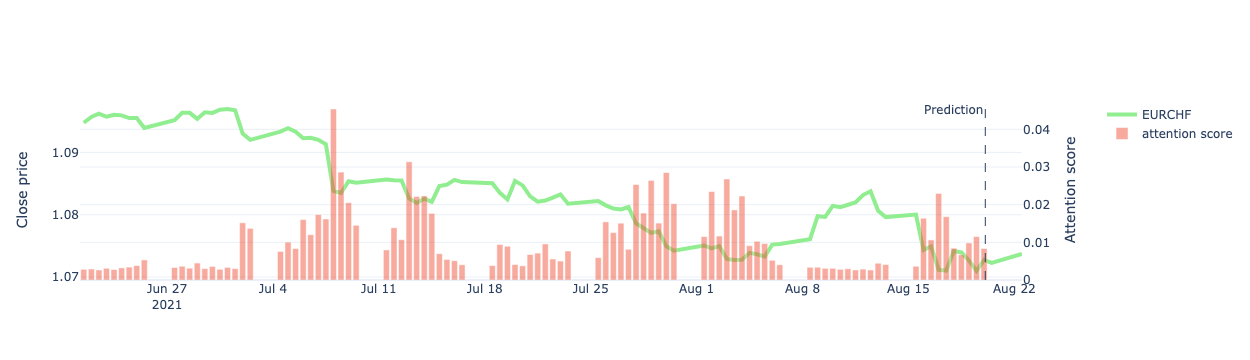

In [432]:

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.update_layout(template='plotly_white')
fig.add_trace(go.Scatter(x=sequence['datetime'], y=sequence['close'], name='EURCHF',
                    line=dict(color='lightgreen', width=4)))
fig.add_trace(go.Bar(x=sequence['datetime'], y=average_score_per_day['head_0'], name='attention score',opacity=0.5), secondary_y=True)
fig.add_vline(x=sequence.iloc[config.seq_len-1,:]['datetime'].timestamp() * 1000, line_width=1, line_dash="dash", 
              annotation_text="Prediction", annotation_position="top left")
fig.update_yaxes(title_text="Close price", secondary_y=False)
fig.update_yaxes(title_text='Attention score', secondary_y=True)


In [409]:
specs=[[{"secondary_y": True}, {} ],[{"secondary_y": True}, {} ], [{"secondary_y": True}, {} ], [{"secondary_y": True}, {} ]]

In [410]:
specs_short=[[{"secondary_y": True}, {} ]]

In [403]:
colorbar_position = [0.9, 0.62, 0.35, 0.1]

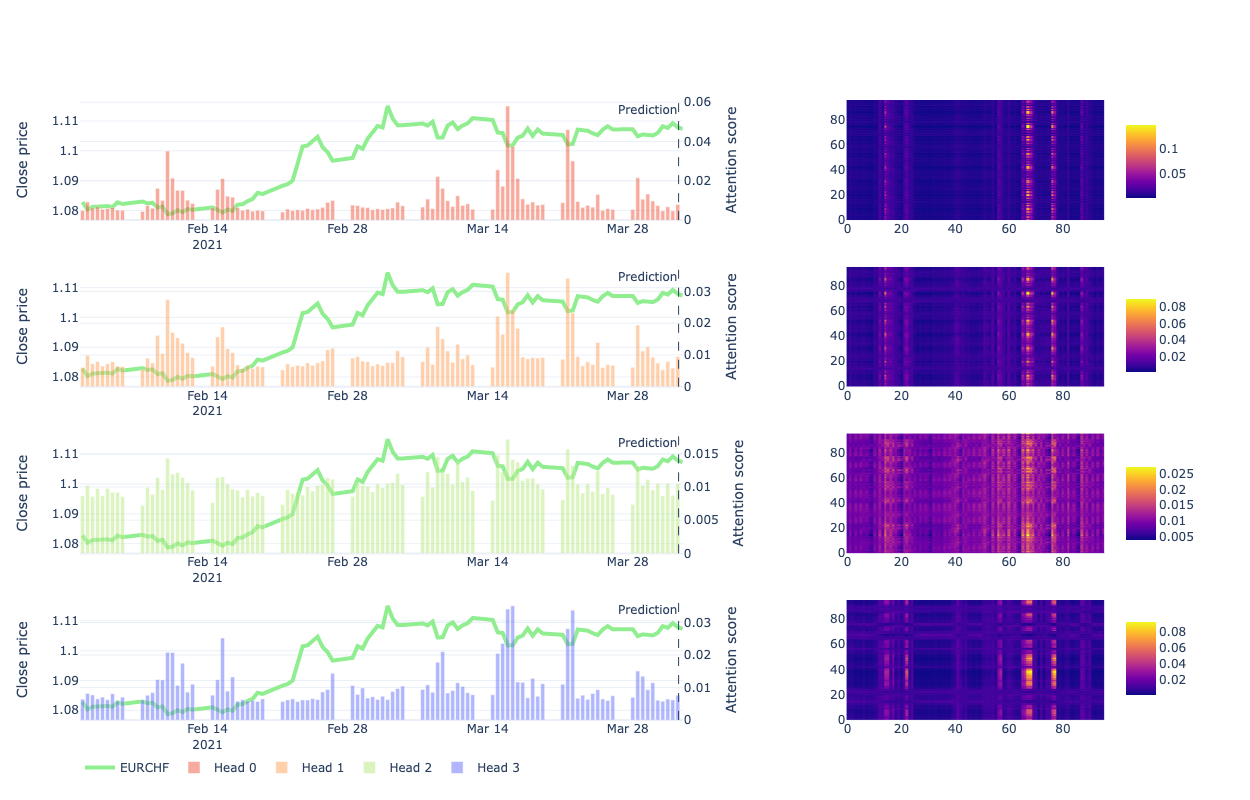

In [404]:
fig = make_subplots(rows=4, cols=2, specs=specs, column_widths=[0.7, 0.3], horizontal_spacing = 0.15)
fig.update_layout(template='plotly_white', width=1200, height=800) #  showlegend=False

for i, head in enumerate(average_score_per_day):

    if i==0:
        fig.add_trace(go.Scatter(x=sequence['datetime'], y=sequence['close'], name='EURCHF', 
                            line=dict(color='lightgreen', width=4)), row=i+1, col=1)
    else: 
        fig.add_trace(go.Scatter(x=sequence['datetime'], y=sequence['close'], showlegend = False,
                        line=dict(color='lightgreen', width=4)), row=i+1, col=1)
    fig.add_trace(go.Bar(x=sequence['datetime'], y=average_score_per_day[head] ,opacity=0.5, name='Head {}'.format(i)), secondary_y=True, row=i+1, col=1)
    fig.add_vline(x=sequence.iloc[config.seq_len-1,:]['datetime'].timestamp() * 1000, line_width=1, line_dash="dash", 
                  annotation_text="Prediction", annotation_position="top left", row=i+1, col=1)
    fig.update_yaxes(title_text="Close price", secondary_y=False, row=i+1, col=1)
    fig.update_yaxes(title_text='Attention score', secondary_y=True, row=i+1, col=1)

    fig.add_trace(go.Heatmap(
                       z=viz_weights[0, i, :, :],
                       hoverongaps = False, colorbar={"len": 0.15}, colorbar_y=colorbar_position[i], colorbar_x=0.95), row=i+1, col=2)
    
    fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=-0.1,
    x=0
))

fig.show()
fig.write_image(os.path.join(config.package_directory, 'models','attention_obs_{}.png'.format(obs)))

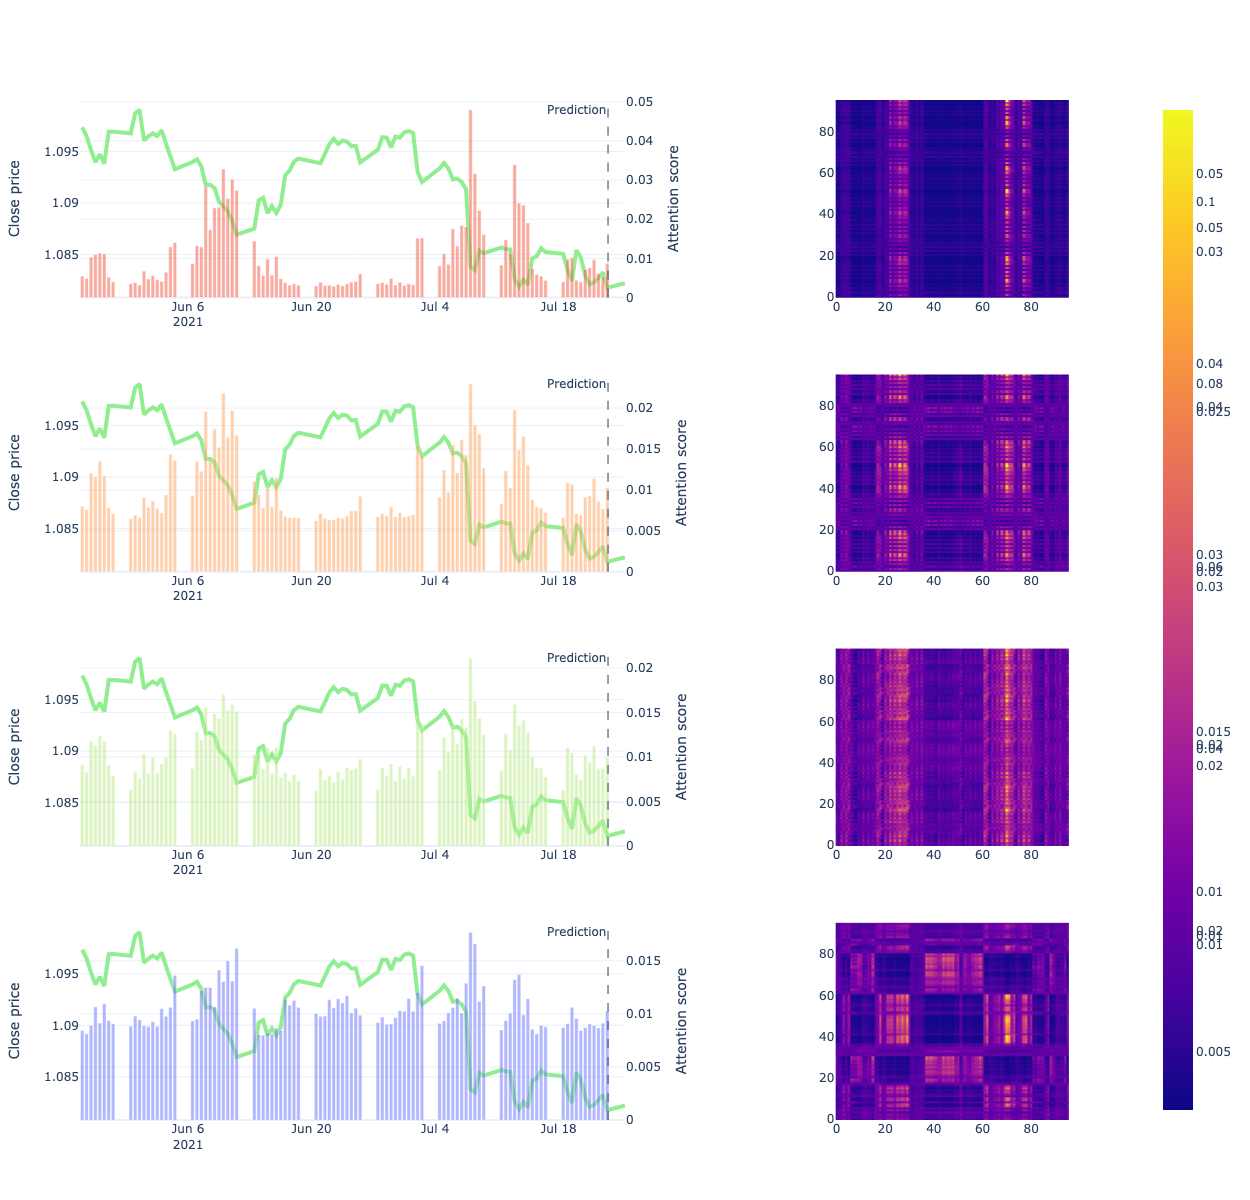

In [222]:
fig = make_subplots(rows=4, cols=2, specs=specs, column_widths=[0.7, 0.3])
fig.update_layout(template='plotly_white', width=1200, height=1200, showlegend=False)

for i, head in enumerate(average_score_per_day):

    fig.add_trace(go.Scatter(x=sequence['datetime'], y=sequence['close'], 
                        line=dict(color='lightgreen', width=4)), row=i+1, col=1)
    fig.add_trace(go.Bar(x=sequence['datetime'], y=average_score_per_day[head] ,opacity=0.5), secondary_y=True, row=i+1, col=1)
    fig.add_vline(x=sequence.iloc[config.seq_len-1,:]['datetime'].timestamp() * 1000, line_width=1, line_dash="dash", 
                  annotation_text="Prediction", annotation_position="top left", row=i+1, col=1)
    fig.update_yaxes(title_text="Close price", secondary_y=False, row=i+1, col=1)
    fig.update_yaxes(title_text='Attention score', secondary_y=True, row=i+1, col=1)

    fig.add_trace(go.Heatmap(
                       z=viz_weights[0, i, :, :],
                       hoverongaps = False), row=i+1, col=2)



fig.show()

head_0
head_1
head_2
head_3


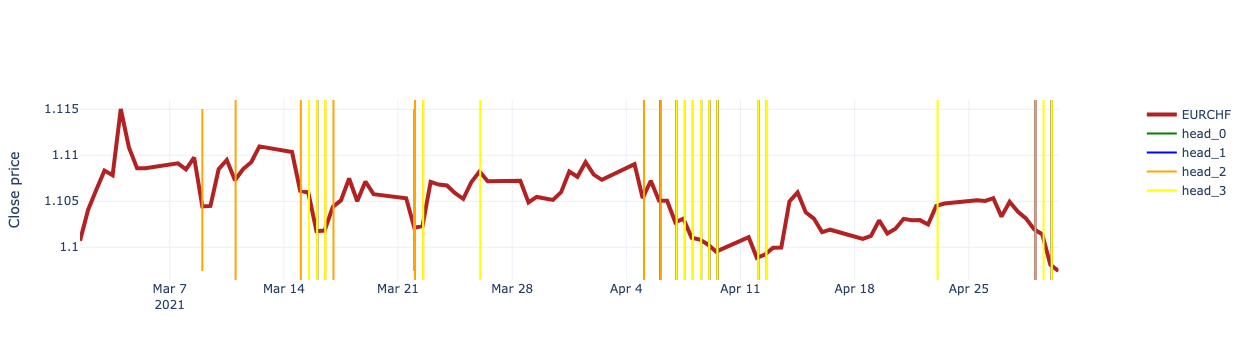

In [200]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
y_min = sequence['close'].min()
y_max = sequence['close'].max()

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.update_layout(template='plotly_white')
fig.add_trace(go.Scatter(x=sequence['datetime'], y=sequence['close'], name='EURCHF',
                    line=dict(color='firebrick', width=4)))
for color, head in enumerate(head_attentions):
    print(head)
    for i, row in enumerate(head_attentions[head]):
        if i == 0:
            fig.add_trace(go.Scatter(x=[sequence.iloc[row,:]['datetime'],sequence.iloc[row,:]['datetime']] , 
                             y=[y_min,y_max], 
                             mode='lines', 
                             line=dict(color=colors[color], width=2),
                             name=head))
        else:
            fig.add_vline(x=sequence.iloc[row,:]['datetime'].timestamp() * 1000, line_width=2, line_color=colors[color])
        

fig.update_yaxes(title_text="Close price", secondary_y=False)


head_0


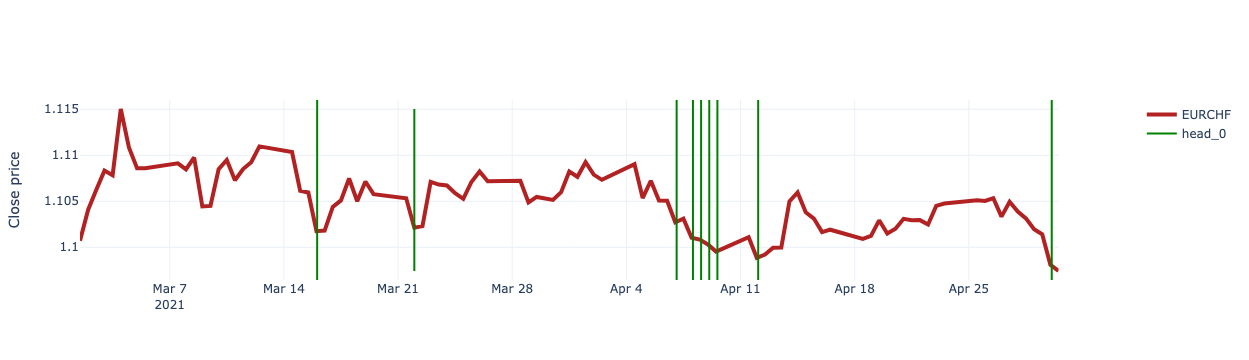

head_1


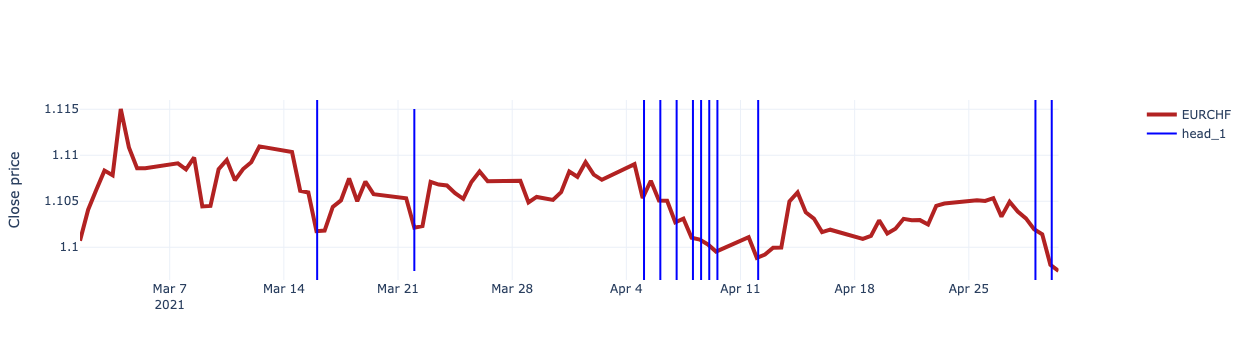

head_2


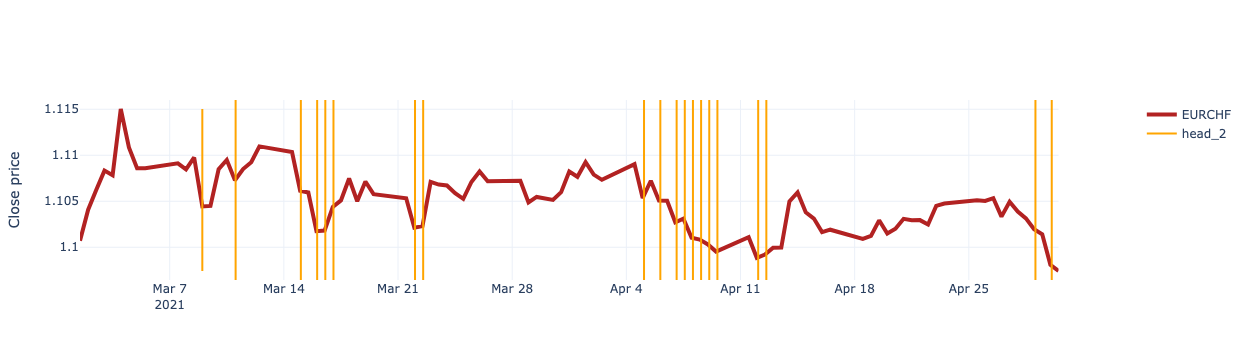

head_3


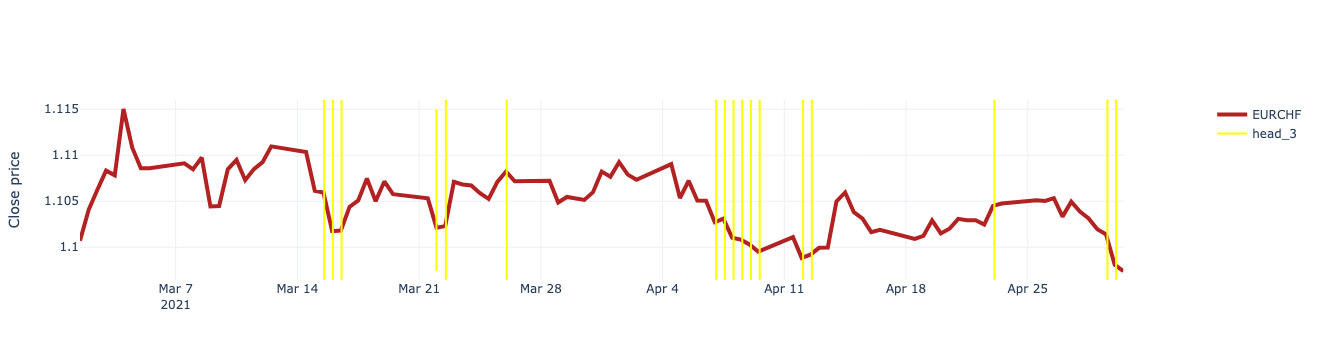

In [201]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
y_min = sequence['close'].min()
y_max = sequence['close'].max()

for color, head in enumerate(head_attentions):
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.update_layout(template='plotly_white')
    fig.add_trace(go.Scatter(x=sequence['datetime'], y=sequence['close'], name='EURCHF',
                        line=dict(color='firebrick', width=4)))

    print(head)
    for i, row in enumerate(head_attentions[head]):
        if i == 0:
            fig.add_trace(go.Scatter(x=[sequence.iloc[row,:]['datetime'],sequence.iloc[row,:]['datetime']] , 
                             y=[y_min,y_max], 
                             mode='lines', 
                             line=dict(color=colors[color], width=2),
                             name=head))
        else:
            fig.add_vline(x=sequence.iloc[row,:]['datetime'].timestamp() * 1000, line_width=2, line_color=colors[color])
        

    fig.update_yaxes(title_text="Close price", secondary_y=False)
    fig.show()

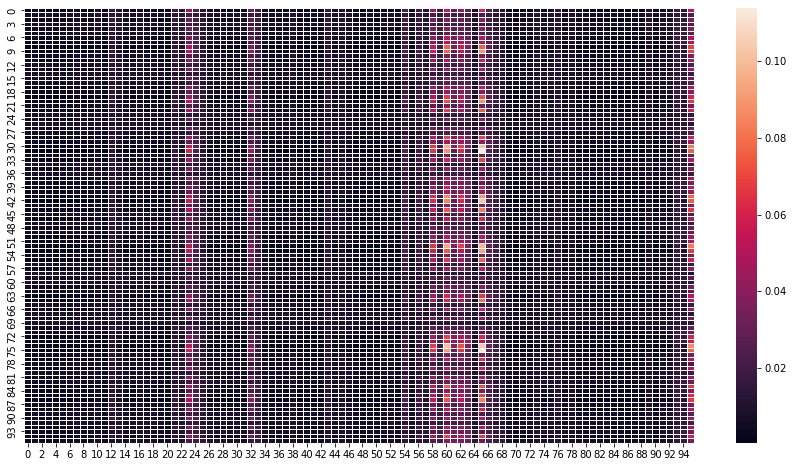

In [202]:
plt.figure(figsize=(15,8))
ax = sb.heatmap(viz_weights[0, 0, :, :], linewidth=0.5)
plt.show()

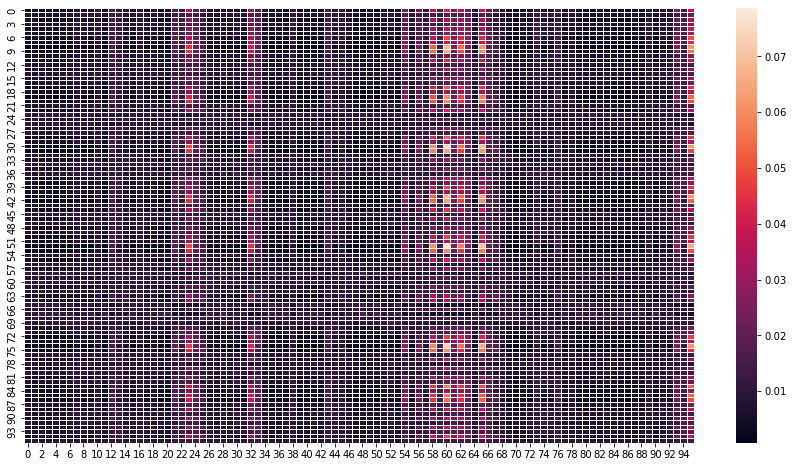

In [203]:
plt.figure(figsize=(15,8))
ax = sb.heatmap(viz_weights[0, 1, :, :], linewidth=0.5)
plt.show()

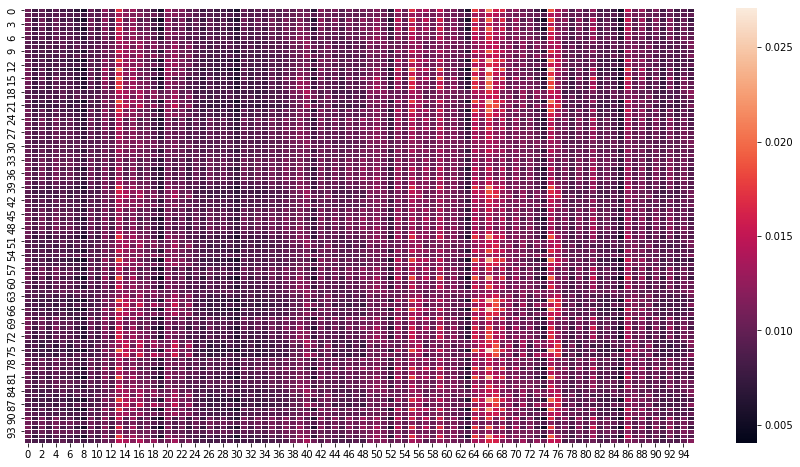

In [176]:
plt.figure(figsize=(15,8))
ax = sb.heatmap(viz_weights[0, 2, :, :], linewidth=0.5)
plt.show()

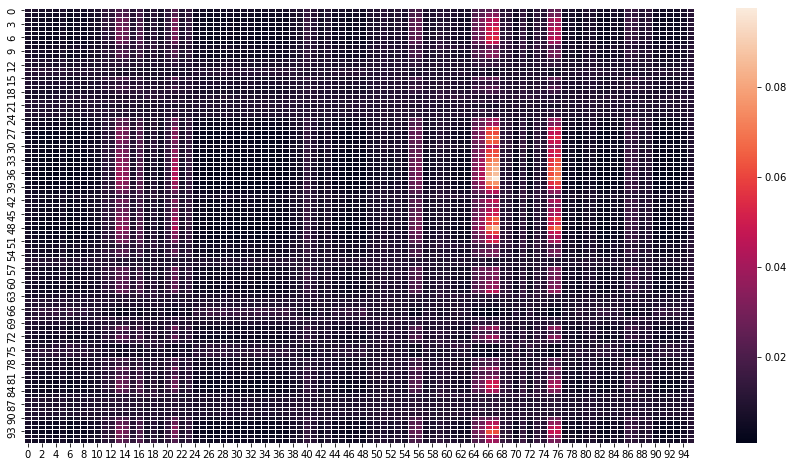

In [177]:
plt.figure(figsize=(15,8))
ax = sb.heatmap(viz_weights[0, 3, :, :], linewidth=0.5)
plt.show()

In [178]:
layer_2_output

<tf.Tensor: shape=(1, 96, 40), dtype=float32, numpy=
array([[[-0.80866325, -0.8192917 , -0.829879  , ...,  0.34529567,
          1.6225768 ,  1.1701603 ],
        [-0.95168984, -0.8944667 , -0.85020375, ...,  0.3099085 ,
          1.602222  ,  0.9949924 ],
        [-0.88577896, -0.8610002 , -0.8049606 , ...,  0.33903846,
          1.6554885 , -0.496643  ],
        ...,
        [-0.7383903 , -0.76192605, -0.8379252 , ...,  0.2664223 ,
         -0.02423853, -1.5787987 ],
        [-0.64489913, -0.648972  , -0.8156587 , ...,  0.54192877,
         -1.9213022 , -0.5462892 ],
        [-0.7774335 , -0.7387297 , -0.7467194 , ...,  0.44632757,
         -1.9688132 , -0.56026137]]], dtype=float32)>

In [37]:
model.layers[3]

In [5]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 40)]     0                                            
__________________________________________________________________________________________________
position_embedding_layer (Posit (None, 96, 40)       3840        input_1[0][0]                    
__________________________________________________________________________________________________
layer_normalization (LayerNorma (None, 96, 40)       80          position_embedding_layer[0][0]   
__________________________________________________________________________________________________
multi_head_attention (MultiHead (None, 96, 40)       41768       layer_normalization[0][0]        
                                                                 layer_normalization[0][0]    

In [9]:
mlflow.set_experiment(experiment_name='hist_data' + '_' + config.model + '_' +
                                      str(config.nb_classes) + '_' +
                                      config.freq + '_' + str(config.steps_ahead) + '_' +
                                      str(config.seq_len))

In [10]:
model.evaluate(X_val, y_val_cat)
test_loss, test_acc = model.evaluate(X_test, y_test_cat)
logger.info('Test accuracy : {}'.format(test_acc))
logger.info('Test loss : {}'.format(test_loss))
mlflow.log_metric("test_acc", test_acc)
mlflow.log_metric("test_loss", test_loss)
mlflow.log_metric("test_loss", test_loss)
mlflow.set_tag('currency', config.currency)
mlflow.set_tag('frequency', config.freq)
mlflow.set_tag('steps_ahead', config.steps_ahead)
mlflow.log_metric('y_distribution', y.mean())
mlflow.log_metric('y_val_distribution', y_val.mean())
mlflow.log_metric('y_test_distribution', y_test.mean())
mlflow.log_metric('cost', config.pips)
mlflow.log_metric('seq_len', config.seq_len)

191/191 [==============================] - 18s 95ms/step - loss: 0.6861 - accuracy: 0.5491


2022-08-21 18:07:36,937 - root - Test accuracy : 0.5491158962249756
2022-08-21 18:07:36,938 - root - Test loss : 0.6861350536346436


In [11]:
y_pred = model.predict(X_test)
y_pred_class = y_pred.argmax(axis=-1)

roc_auc = roc_auc_score(y_test, y_pred_class)
f1 = f1_score(y_test, y_pred_class)
logger.info('roc_auc : {}'.format(roc_auc))
logger.info('f1 : {}'.format(f1))
mlflow.log_metric('roc_auc', roc_auc)
mlflow.log_metric('f1', f1)

if 'JPY' in config.currency:
    df['cost'] = (config.pips / 100) / df['close']
else:
    df['cost'] = (config.pips / 10000) / df['close']

start_date = joblib.load(os.path.join(config.package_directory, 'models',
                                      'first_sequence_ends_{}_{}_{}.save'.format('test',
                                                                                 config.currency,
                                                                                 config.freq)))
end_date = joblib.load(os.path.join(config.package_directory, 'models',
                                    'last_sequence_ends_{}_{}_{}.save'.format('test',
                                                                              config.currency,
                                                                              config.freq)))
lower_bounds = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
upper_bounds = [1 - lower for lower in lower_bounds]


2022-08-21 18:20:40,055 - root - roc_auc : 0.5491159135559921
2022-08-21 18:20:40,057 - root - f1 : 0.5066284485847367


In [12]:
lower_bounds = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
upper_bounds = [1 - lower for lower in lower_bounds]

for lower_bound, upper_bound in zip(lower_bounds, upper_bounds):
    portfolio_result, hit_ratio, time_active = compute_profitability_classes(df, y_pred, start_date,
                                                                             end_date, lower_bound,
                                                                             upper_bound)
    mlflow.log_metric("portfolio_result_{}_{}".format(lower_bound, upper_bound), portfolio_result)
    mlflow.log_metric("hit_ratio_{}_{}".format(lower_bound, upper_bound), hit_ratio)
    mlflow.log_metric("time_active_{}_{}".format(lower_bound, upper_bound), time_active)
    mlflow.log_artifact(os.path.join(config.package_directory, 'models',
                                     'portfolio_evolution_{}_{}_{}_{}_{}.png'.
                                     format(config.model, config.currency, config.nb_classes,
                                            lower_bound, upper_bound)))


/home/jupyter/ml_investing_wne/src/ml_investing_wne/helper.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  'Europe/Warsaw').dt.tz_localize(None)
/home/jupyter/ml_investing_wne/src/ml_investing_wne/helper.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['hour_waw'] = prediction['datetime_waw'].dt.time
/home/jupyter/ml_investing_wne/src/ml_investing_wne/helper.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i